In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

#print(os.listdir("../input/"))
print(os.listdir("input/"))

['caiso_hourly.csv', 'pred_file.csv']


Using TensorFlow backend.


In [2]:
#import caiso_hourly.csv data for analysis

fpath='input/caiso_hourly.csv'

df=pd.read_csv(fpath)
df.head()

,Datetime,CAISO_MW
0,1/1/2016 0:00,23296
1,1/1/2016 1:00,23419
2,1/1/2016 2:00,22654
3,1/1/2016 3:00,22039
4,1/1/2016 4:00,21705


In [3]:
#use datetime(2016-01-01 01:00:00,...) as index
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,CAISO_MW
Datetime,
2016-01-01 00:00:00,23296
2016-01-01 01:00:00,23419
2016-01-01 02:00:00,22654
2016-01-01 03:00:00,22039
2016-01-01 04:00:00,21705


In [4]:
#checking missing data
df.isna().sum()

CAISO_MW    0
dtype: int64

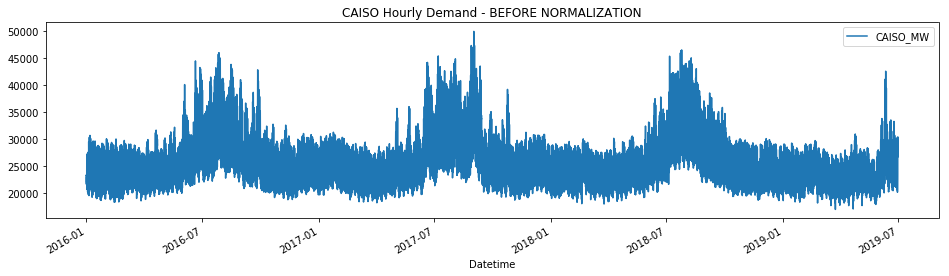

In [5]:
# first plot, no normalization yet

df.plot(figsize=(16,4),legend=True)
#plt.savefig('Demand1.png')
plt.title('CAISO Hourly Demand - BEFORE NORMALIZATION')
plt.savefig('Demand_bef.png')
#fig = plt.figure()
plt.show()

In [6]:
# normalize the data and shape
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['CAISO_MW']=scaler.fit_transform(df['CAISO_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

C:\Users\computer\Anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(30647, 1)

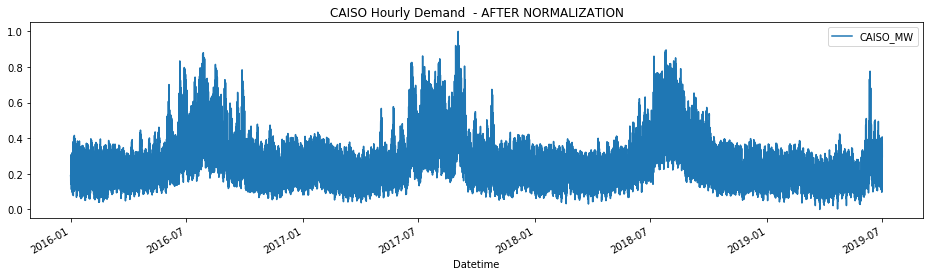

In [7]:
df_norm.plot(figsize=(16,4),legend=True)
plt.title('CAISO Hourly Demand  - AFTER NORMALIZATION')
plt.savefig('Demand_aft.png')
plt.show()

In [8]:

#plt.savefig("HourlyDemandNorm.png")
# the above is saving blank

df_norm.shape

(30647, 1)

In [9]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    # last 5647 data as test
    X_test = X_train[25000:]             
    y_test = y_train[25000:]
    
    # first 25000 data to train
    X_train = X_train[:25000]           
    y_train = y_train[:25000]
    
    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # reshape for input into RNN models
    X_train = np.reshape(X_train, (25000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [10]:
#create train, test data
seq_len = 20 #choose sequence length
X_train, y_train, X_test, y_test = load_data(df, seq_len)
#print(X_test)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (25000, 20, 1)
y_train.shape =  (25000,)
X_test.shape =  (5627, 20, 1)
y_test.shape =  (5627,)


In [11]:
#run sequential model

In [12]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_3 (Dropout)  

In [13]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
25000/25000 [==============================] - 5s 185us/step - loss: 0.1781 3s - 
Epoch 2/10
25000/25000 [==============================] - 3s 101us/step - loss: 0.0645
Epoch 3/10
25000/25000 [==============================] - 2s 93us/step - loss: 0.0395: 0s - loss: 0.
Epoch 4/10
25000/25000 [==============================] - 3s 104us/step - loss: 0.0278
Epoch 5/10
25000/25000 [==============================] - 2s 93us/step - loss: 0.0217
Epoch 6/10
25000/25000 [==============================] - 3s 107us/step - loss: 0.0175
Epoch 7/10
25000/25000 [==============================] - 2s 98us/step - loss: 0.0147
Epoch 8/10
25000/25000 [==============================] - 3s 107us/step - loss: 0.0124
Epoch 9/10
25000/25000 [==============================] - 2s 99us/step - loss: 0.0109
Epoch 10/10
25000/25000 [==============================] - 2s 94us/step - loss: 0.0098


In [14]:
#save the model in local folder
#filename="rnn_modela.mom"
filename="rnn_modela.h5"
pickle.dump(rnn_model, open(filename, 'wb'))
load_model = pickle.load(open(filename, 'rb'))

#rnn_predictions = rnn_model.predict(X_test)
rnn_predictions = load_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)
#print(rnn_predictions)

R2 Score of RNN model =  0.8766200776198115


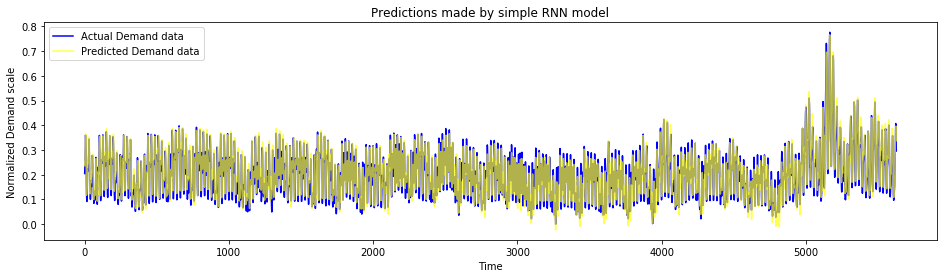

In [15]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual Demand data')
    plt.plot(predicted, alpha=0.7, color='yellow',label='Predicted Demand data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized Demand scale')
    plt.legend()
   # plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")
plt.savefig('simpleRNN.png')

In [16]:
# Run the second ML model

In [17]:
# Long Short Term Memory Model

In [18]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total para

In [19]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=500)

Epoch 1/10
25000/25000 [==============================] - 13s 523us/step - loss: 0.0266
Epoch 2/10
25000/25000 [==============================] - 7s 269us/step - loss: 0.0179
Epoch 3/10
25000/25000 [==============================] - 8s 309us/step - loss: 0.0137
Epoch 4/10
25000/25000 [==============================] - 8s 305us/step - loss: 0.0058
Epoch 5/10
25000/25000 [==============================] - 12s 475us/step - loss: 0.0048
Epoch 6/10
25000/25000 [==============================] - 12s 464us/step - loss: 0.0043
Epoch 7/10
25000/25000 [==============================] - 12s 461us/step - loss: 0.0038
Epoch 8/10
25000/25000 [==============================] - 12s 464us/step - loss: 0.0033
Epoch 9/10
25000/25000 [==============================] - 12s 468us/step - loss: 0.0029
Epoch 10/10
25000/25000 [==============================] - 15s 593us/step - loss: 0.0025


In [20]:
# save the lstm model
filename1="lstm_modela.h5"
pickle.dump(lstm_model, open(filename1, 'wb'))
load_model1 = pickle.load(open(filename1, 'rb'))
lstm_predictions = load_model1.predict(X_test)
#lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.7838702328476841


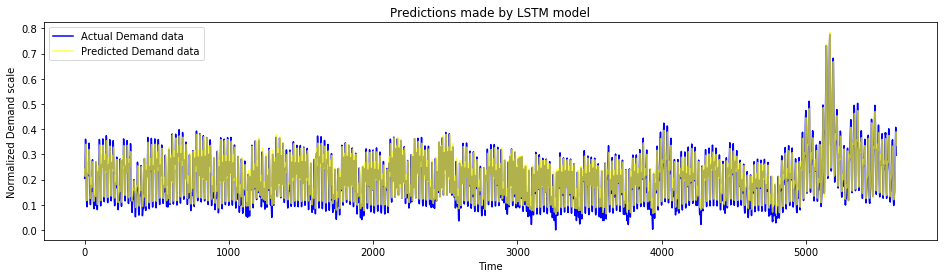

In [21]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")
plt.savefig('LSTM.png')

In [22]:
# compare both RNN and LSTM testing to the original values

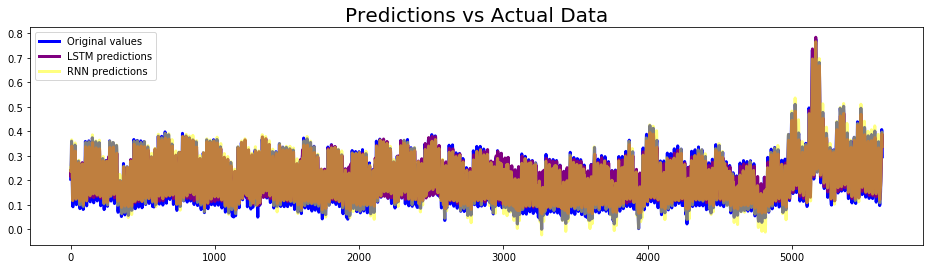

In [23]:
plt.figure(figsize=(16,4))

plt.plot(y_test, c="blue", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="purple", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="yellow", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs Actual Data", fontsize=20)
plt.savefig('Pred_v_Actual.png')
plt.show()

In [24]:
# prediction on next two month's demand curve

In [25]:
def load_datanew(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last after 2 data as test
    X_test = X_train[2:]             
    y_test = y_train[2:]
    
    #2 ignore first two 
    X_train = X_train[:2]           
    y_train = y_train[:2]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape for input into models
    X_train = np.reshape(X_train, (2, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [26]:
fpathnew='input/pred_file.csv'

dfnew = pd.read_csv(fpathnew, index_col='Datetime', parse_dates=['Datetime'])
normalize_data(dfnew).shape
#print(dfnew.head())
X_train_new, y_train_new, X_test_new, y_test_new = load_datanew(dfnew, seq_len)

#print(X_test_new)
print('X_train.shape new= ',X_train_new.shape)
print('y_train.shape new = ', y_train_new.shape)
print('X_test.shape new = ', X_test_new.shape)
print('y_test.shape new = ',y_test_new.shape)



C:\Users\computer\Anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


X_train.shape new=  (2, 20, 1)
y_train.shape new =  (2,)
X_test.shape new =  (1442, 20, 1)
y_test.shape new =  (1442,)


In [27]:
# recurrent neural network predictions R2 Score
rnn_predictions = load_model.predict(X_test_new)
#print(rnn_predictions)
#print(y_test_new)
rnn_score_new = r2_score(y_test_new,rnn_predictions)
print("R2 Score of RNN model new = ",rnn_score_new)

R2 Score of RNN model new =  0.959323505139664


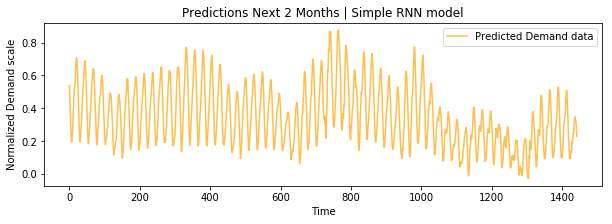

In [28]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(10,3))
    #plt.plot(test, color='blue',label='Actual Demand data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted Demand data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized Demand scale')
    plt.legend()
    #plt.show()
    
plot_predictions(y_test_new, rnn_predictions, "Predictions Next 2 Months | Simple RNN model")
plt.savefig('newRNN.png')

In [29]:
# predict lstm prediction R2 score
lstm_predictions = load_model1.predict(X_test_new)
#print(lstm_predictions)
print(X_test_new)

lstm_score_new = r2_score(y_test_new, lstm_predictions)
print("R^2 Score of LSTM model new = ",lstm_score_new)


[[[0.19733458]
  [0.17505595]
  [0.16015899]
  ...
  [0.68542703]
  [0.63582618]
  [0.61478339]]

 [[0.17505595]
  [0.16015899]
  [0.16797488]
  ...
  [0.63582618]
  [0.61478339]
  [0.55997194]]

 [[0.16015899]
  [0.16797488]
  [0.20658673]
  ...
  [0.61478339]
  [0.55997194]
  [0.45602726]]

 ...

 [[0.13587628]
  [0.09479275]
  [0.0641304 ]
  ...
  [0.30722469]
  [0.30926217]
  [0.32746585]]

 [[0.09479275]
  [0.0641304 ]
  [0.04839841]
  ...
  [0.30926217]
  [0.32746585]
  [0.29924179]]

 [[0.0641304 ]
  [0.04839841]
  [0.04699556]
  ...
  [0.32746585]
  [0.29924179]
  [0.25561976]]]
R^2 Score of LSTM model new =  0.9610233848939906


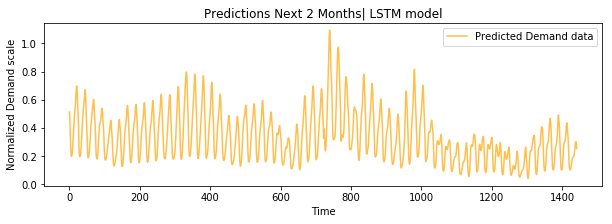

In [30]:


plot_predictions(y_test_new, lstm_predictions, "Predictions Next 2 Months| LSTM model")
plt.savefig('newLSTM.png')
